In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_validate

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print(f"Rows in train.csv = {len(df_train)}")
print(f"Rows in test.csv = {len(df_test)}")
pd.set_option('display.max_colwidth', None)
df_train.head()

Rows in train.csv = 7613
Rows in test.csv = 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [2]:
df_train_pos = df_train[df_train.target == 1]
df_train_neg = df_train[df_train.target == 0]
print(f"No. of positive training examples = {len(df_train_pos)}")
print(f"No. of negative training examples = {len(df_train_neg)}")
train_keywords_unique = df_train.keyword.unique()
print(f"No. of unique keywords = {len(train_keywords_unique)}")
df_train_notnull_keywords = df_train[~df_train.keyword.isnull()]
print(f"No of train examples with keyword not null = {len(df_train_notnull_keywords)}")
df_train_notnull_keywords.head()

No. of positive training examples = 3271
No. of negative training examples = 4342
No. of unique keywords = 222
No of train examples with keyword not null = 7552


,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0


In [3]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Preprocess the tweets 

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import string
import re

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, ' ')
    return text

def process_tweet(df, text, keyword):
    lemmatizer = WordNetLemmatizer()    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)    
    processed_text = []
    stop = stopwords.words("english")
    for tweet, keyword in zip(df[text], df[keyword]):
        tweets_clean = []        
        # remove stock market tickers like $GE
        #tweet = tweet + " " + keyword
        tweet = re.sub(r'\$\w*', '', tweet)
        # remove old style retweet text "RT"
        tweet = re.sub(r'^RT[\s]+', '', tweet)
        # remove hyperlinks
        tweet = re.sub(r'http\S+', '', tweet)
        # remove hashtags
        # only removing the hash #, @, ... sign from the word
        tweet = re.sub(r'\.{3}|@|#', '', tweet)    
        tweet = clean_special_chars(tweet, punct)
        # remove junk characters which don't have an ascii code
        tweet = tweet.encode("ascii", "ignore").decode("utf-8", "ignore")
        # tokenize tweets        
        tweet_tokens = tokenizer.tokenize(tweet)
        for word in tweet_tokens:
            # remove stopwords and punctuation
            if (word.isalpha() and len(word) > 2 and word not in stop 
                and word not in string.punctuation):
                #stem_word = stemmer.stem(word)  # stemming word            
                lem_word = lemmatizer.lemmatize(word)
                tweets_clean.append(lem_word) 
        processed_text.append(" ".join(tweets_clean))        
    df['processed_text'] = np.array(processed_text)

In [5]:
df_train["keyword"] = df_train["keyword"].fillna("no_keyword")
df_test["keyword"] = df_test["keyword"].fillna("no_keyword")
process_tweet(df_train, 'text', "keyword")
process_tweet(df_test, 'text', "keyword")
df_train["prcsd_tweet_len"] = df_train["processed_text"].apply(lambda row: len(row.split()))
df_test["prcsd_tweet_len"] = df_test["processed_text"].apply(lambda row: len(row.split()))

In [6]:
df_train["prcsd_tweet_len"].mean()

8.744384605280441

In [7]:
df_train.iloc[50:52, :]

,id,keyword,location,text,target,processed_text,prcsd_tweet_len
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k,1,deputy man shot brighton home set ablaze,7
51,74,ablaze,India,Man wife get six years jail for setting ablaze niece\nhttp://t.co/eV1ahOUCZA,1,man wife get six year jail setting ablaze niece,9


In [8]:

df_test.head()

,id,keyword,location,text,processed_text,prcsd_tweet_len
0,0,no_keyword,NaN,Just happened a terrible car crash,happened terrible car crash,4
1,2,no_keyword,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different city stay safe everyone,7
2,3,no_keyword,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose fleeing across street cannot save,10
3,9,no_keyword,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,4
4,11,no_keyword,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,5


## Let us try some deep learning techniques now

In [9]:
def get_word_embedding_dict(embedding_file_path):
    embedding_dict = {}
    with open(embedding_file_path, "r") as f:
        # https://stackoverflow.com/questions/8009882/how-to-read-a-large-file-line-by-line
        for line in f:
            values = line.split()
            word = values[0]
            word_vec = np.asarray(values[1:], "float32")
            embedding_dict[word] = word_vec
    return embedding_dict        

#glove_embedding_dict = get_word_embedding_dict("../../../glove.twitter.27B/glove.twitter.27B.200d.txt")

In [10]:
import torchtext

glove_emb = torchtext.vocab.GloVe(name="twitter.27B", dim=200)

In [11]:
# build tweets vocab from training data

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(df):
    for index, row in df.iterrows():
        yield row["processed_text"].split()
    
tweet_vocab = build_vocab_from_iterator(yield_tokens(df_train), specials=["<unk>", "<pad>"])    

In [12]:
import torch
import torch.nn as nn

# For the problem specific vocab, get the embedding vectors from the pre-trained embedding
# for each word in vocab and return a matrix of shape vocab_size, embedding_dim. This matrix
# will be the pretrained embedding weight matrix which we will use to create the embedding layer
def get_vocab_pt_emb_matrix(text_vocab, emb):
    embedding_matrix = []
    for token in text_vocab.get_itos():
        embedding_matrix.append(emb[token])
    return torch.stack(embedding_matrix)

pt_emb_weights = get_vocab_pt_emb_matrix(tweet_vocab, glove_emb)
pt_emb_layer = nn.Embedding.from_pretrained(pt_emb_weights)
#result = pt_emb_layer(torch.LongTensor([1,2]))

In [13]:
glove_emb["<pad>"]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
# [(index, token) for index, token in enumerate(glove_emb.itos) if token == "<unk>"]
#pt_emb_layer(torch.LongTensor([1]))

In [15]:
from torch.nn.utils.rnn import pad_sequence

df_train["vectorized_tweet"] = df_train["processed_text"].apply(
    lambda row:torch.LongTensor(tweet_vocab.lookup_indices(row.split()))
    )

#x_seq = df_train["vectorized_tweet"].values.tolist()
# the index for 'pad' token in tweet_vocab is 1.
#x_padded_seq = pad_sequence(x_seq, batch_first=True, padding_value=1)

In [90]:
from torch.utils.data import Dataset, DataLoader

class VectorizedTweetDataSet(Dataset):
    def __init__(self, tweet_vecs, labels):
        self.tweet_vecs = tweet_vecs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet_vec = self.tweet_vecs[idx]
        label = self.labels[idx]
        tweet_len = len(tweet_vec)
        return (tweet_vec, label)


In [91]:
# If the goal is to train with mini-batches, one needs to pad the sequences in each batch. 
# In other words, given a mini-batch of size N, if the length of the largest sequence is L, 
# one needs to pad every sequence with a length of smaller than L with zeros and make their 
# lengths equal to L. Moreover, it is important that the sequences in the batch are in the 
# descending order.
def pad_collate(batch):
    # Each element in the batch is a tuple (data, label)
    # sort the batch (based on tweet word count) in descending order
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    # Also need to store the length of each sequence.This is later needed in order to unpad 
    # the sequences
    seq_len = torch.Tensor([len(x) for x in sequences])
    labels = torch.Tensor([x[1] for x in sorted_batch])
    return sequences_padded, seq_len, labels


In [121]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

tweet_ds = VectorizedTweetDataSet(df_train["vectorized_tweet"].values, df_train["target"].values)
# split the tweet_ds into train and validation datasets with 80:20 ratio
train_idx, val_idx = train_test_split(list(range(len(tweet_ds))), test_size=0.2, random_state=42)
train_ds = Subset(tweet_ds, train_idx)
val_ds = Subset(tweet_ds, val_idx)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=pad_collate)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True, collate_fn=pad_collate)

In [122]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DisasterModel(nn.Module):
    """The RNN model."""
    def __init__(self, vocab_size, num_layers, is_bidirect, emb_dim, hidden_dim, out_dim, 
                drop_prob=0.5, **kwargs):
        super(DisasterModel, self).__init__(**kwargs)
        
        self.vocab_size = vocab_size
        self.num_layers = num_layers        
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim        
        self.output_dim = out_dim        
        # Embedding layer
        self.emb_layer = nn.Embedding(self.vocab_size, emb_dim)
        # LSTM Layer        
        self.lstm_layer = nn.LSTM(
                        input_size=emb_dim, hidden_size=hidden_dim, batch_first=True, 
                        bidirectional=is_bidirect, num_layers=num_layers, dropout=drop_prob
                        )
        self.dropout = nn.Dropout(p = drop_prob)                        
        
        # If the RNN is bidirectional `num_directions` should be 2, else it should be 1.        
        if not is_bidirect:
            self.num_directions = 1
            # The linear layer is for making predictions 
            # input to linear output layer is of shape num_steps, batch_size, num_hiddens
            # and output is of shape num_steps, batch_size, vocab_size
            # Wya is of shape (vocab_size, num_hiddens), a_out is of shape (num_hiddens, 1)
            # yt_pred = np.dot(Wya, a_out) + b is of shape (vocab_size, 1)
            # replace 1 with m (batch_size) and add num_steps as the first dimension to have
            # vectorized form of the output
            self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        else:       
            self.num_directions = 2     
            self.linear = nn.Linear(self.hidden_dim * 2, self.output_dim)
        # The activation layer which converts output to 0 or 1            
        self.act = nn.Sigmoid()            

    def forward(self, inputs, input_lengths, state):        
        # inputs is of shape batch_size, num_steps(sequence length which is the length of
        # longest text sequence). Each row of inputs is 1d LongTensor array of length 
        # num_steps containing word index. Using the embedding layer we want to convert
        # each word index to its corresponding word vector of dimension emb_dim
        batch_size = inputs.size(0)
        num_steps = inputs.size(1)        
        # embeds is of shape batch_size * num_steps * emb_dim and is the input to lstm layer
        embeds = self.emb_layer(inputs)        
        # pack_padded_sequence before feeding into LSTM. This is required so pytorch knows
        # which elements of the sequence are padded ones and ignore them in computation.
        # This step is done only after the embedding step
        embeds_pack = pack_padded_sequence(embeds, input_lengths, batch_first=True)
        # lstm_out is of shape batch_size * num_steps * hidden_size and contains the output
        # features (h_t) from the last layer of LSTM for each t
        # h_n is of shape num_layers * batch_size * hidden_size and contains the final hidden 
        # state for each element in the batch i.e. hidden state at t_end
        # same for c_n as h_n except that it is the final cell state
        lstm_out_pack, (h_n, c_n) = self.lstm_layer(embeds_pack)
        # unpack the output
        lstm_out, lstm_out_len = pad_packed_sequence(lstm_out_pack, batch_first=True)        
        # tensor flattening works only if tensor is contiguous
        # https://discuss.pytorch.org/t/contigious-vs-non-contigious-tensor/30107/2
        # flatten lstm_out from 3d to 2d with shape (batch_size * num_steps), hidden_dim)
        # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)        
        lstm_out = h_n[-1, :, :]
        #print(f"h_n.shape = {h_n.shape}")
        #print(f"h_n = {h_n[1, 0, :]}")
        #print(f"lstm_out.shape = {lstm_out.shape}")
        #print(f"lstm_out_len = {lstm_out_len}")
        #print(f"lstm_out = {lstm_out}")
        # regularize lstm output by applying dropout
        out = self.dropout(lstm_out)        
        # The the output Y of fully connected rnn layer has the shape of 
        # (`num_steps` * `batch_size`, `num_hiddens`). This Y is then fed as input to the 
        # output fully connected linear layer which produces the prediction in the output shape of 
        # (`num_steps` * `batch_size`, `output_dim`).        
        output = self.linear(out)
        #print(f"output.shape = {output.shape}")
        #print(f"output = {output}")
        # reshape output to batch_size, num_steps, output_dim
        #output = output.view(batch_size, -1, self.output_dim)
        #print(f"output.shape = {output.shape}")
        #print(f"output = {output}")
        # reshape output again to batch_size, output_dim. The last element of middle dimension
        # i.e. num_steps is taken i.e. for each item in the batch the output is the hidden state
        # from the last layer of LSTM for t = t_end
        #output = output[:, -1, :]
        output = self.act(output)
        return output, (h_n, c_n)

    def init_state(self, device, batch_size=1):
        """ Initialize the hidden state i.e. initialize all the neurons in all the hidden layers 
        to zero"""
        if not isinstance(self.lstm_layer, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.num_layers,
                                batch_size, self.hidden_dim), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states (h0, c0). h0 = initial
            # hidden state for each element in the batch, c0 = initial cell state
            # for each element in the batch
            return (torch.zeros((self.num_directions * self.num_layers,
                                 batch_size, self.hidden_dim), device=device),
                    torch.zeros((self.num_directions * self.num_layers,
                                 batch_size, self.hidden_dim), device=device))

In [123]:
# Dimensions of various layers and other parameters to model
vocab_size = len(tweet_vocab)
emb_dim = 200
hidden_dim = 256
out_dim = 1
num_layers = 2
is_bidirectional = False
drop_out_prob = 0.5 

model = DisasterModel(vocab_size = vocab_size, num_layers = num_layers, is_bidirect = is_bidirectional,  
                emb_dim = emb_dim, hidden_dim = hidden_dim, out_dim = out_dim, 
                drop_prob = drop_out_prob)

# copy the vocab specific weights(emb vectors) from pretrained embeddings to model embedding layer
model.emb_layer.weight.data.copy_(pt_emb_weights)                
print(model)

DisasterModel(
  (emb_layer): Embedding(14568, 200)
  (lstm_layer): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)


In [124]:
import torch.optim as optim
learning_rate = 0.001
# define the optimizer ( we choose mini batch gradient descent with momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# loss function
loss_fn = nn.BCELoss()
batch_size = 64
grad_clip = 5

# metric to measure model performance
def accuracy(y_pred, y):
    # y_pred is in the range 0 to 1. Convert it to 0 or 1 by rounding
    y_pred_round = torch.round(y_pred.squeeze())
    correct = (y_pred_round == y.squeeze()).float()
    acc = correct.sum() / len(correct)
    return acc

acc = accuracy    

In [125]:
def train_epoch(dl, init_hidden, model, loss_fn, optimizer, accuracy, device, batch_size):
    batch_count = 0
    loss_epoch = []
    acc_epoch = []    
    for inputs, input_lengths, labels in dl:
        # create a new hidden state instance for each minibatch to avoid long gradient chains
        # involving all previous minibatches of an epoch
        h = tuple([e.data for e in init_hidden])
        inputs,input_lengths,labels = inputs.to(device),input_lengths.to(device),labels.to(device)
        if inputs.shape[0] != batch_size:
            continue
        #print(f"inputs.shape = {inputs.shape}, input_lengths = {input_lengths}, labels.shape = {labels.shape}")
        # forward pass on one mini batch
        output, hidden = model(inputs, input_lengths, h)        
        # compute the loss
        loss = loss_fn(output.squeeze(), labels.float())
        epoch_acc = accuracy(output, labels)
        #print(f"accuracy on training set batch {batch_count} = {epoch_acc.item()}")
        #print(f"loss on training set batch {batch_count} = {loss.item()}")
        acc_epoch.append(epoch_acc.item())
        loss_epoch.append(loss.item())
        # zero out the model param gradients before running backprop
        optimizer.zero_grad()
        # run backprop to calculate param gradients (dW and db)
        loss.backward()
        # clip the param gradients if they exceed threshold
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        # update the parameters (W and b)
        optimizer.step()
        batch_count += 1
    #print(loss_epoch)        
    #print(epoch_acc)        
    return np.mean(loss_epoch), np.mean(acc_epoch)  

In [126]:
def val_epoch(dl, init_hidden, model, loss_fn, accuracy, device, batch_size):    
    loss_epoch = []
    acc_epoch = []
    for inputs, input_lengths, labels in dl:
        # create a new hidden state instance for each minibatch to avoid long gradient chains
        # involving all previous minibatches of an epoch
        h = tuple([e.data for e in init_hidden])
        inputs,input_lengths,labels = inputs.to(device),input_lengths.to(device),labels.to(device)
        if inputs.shape[0] != batch_size:
            continue
        # forward pass on one mini batch
        output, hidden = model(inputs, input_lengths, h)
        # compute the loss
        loss = loss_fn(output.squeeze(), labels.float())
        epoch_acc = accuracy(output, labels)
        acc_epoch.append(epoch_acc.item())
        loss_epoch.append(loss.item())                
    return np.mean(loss_epoch), np.mean(acc_epoch)  

In [127]:
def get_exec_time(exec_time_secs):
    if exec_time_secs < 60:
        return f"{round(exec_time_secs, 2)} seconds"
    exec_time_rem_sec = exec_time_secs % 60
    exec_time_min = int((exec_time_secs - exec_time_rem_sec) / 60)
    return f"{exec_time_min} min {round(exec_time_rem_sec, 2)} seconds"

def print_epoch_stats(epoch, val_loss_min, train_run_time, train_loss, 
                     train_acc, val_run_time, val_loss, val_acc):
    print(f"=======================================================")
    print(f"Epoch {epoch} :")
    print(f"Execution time on training set = {train_run_time} ")
    print(f"Training loss = {round(train_loss, 4)}, training accuracy = {round(train_acc, 4)}")
    print(f"Execution time on validation set = {val_run_time} ")
    print(f"Validation loss = {round(val_loss, 4)}, validation accuracy = {round(val_acc, 4)}")        
    print(f"=======================================================")        
    if val_loss < val_loss_min:        
        print(f"Validation loss decreased from " +
                f"{round(val_loss_min, 6)} --> {round(val_loss, 6)}. Saving model...")        
        val_loss_min = val_loss                
        torch.save(model, "best_model.pt")           
    return val_loss_min        

In [128]:
import time
           
def training_loop(train_dl, val_dl, model, loss_fn, optimizer, num_epochs, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = True
    model = model.to(device)
    train_start_time = time.time()
    val_loss_min = np.Inf
    train_loss, val_loss = [], []    
    train_acc, val_acc = [], []        
    for epoch in range(num_epochs):
        init_hidden = model.init_state(device = device, batch_size = batch_size)        
        epoch_train_start_time = time.time()
        model.train()
        epoch_train_loss, epoch_train_acc = train_epoch(train_dl, init_hidden, model, loss_fn, 
                                                        optimizer, accuracy, device, batch_size)
        #print(f"Training loss = {epoch_train_loss}, training accuracy = {epoch_train_acc}")                                                        
        epoch_train_end_time = time.time()    
        epoch_train_run_time = get_exec_time(epoch_train_end_time - epoch_train_start_time)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        epoch_val_start_time = time.time()
        model.eval()
        epoch_val_loss, epoch_val_acc = val_epoch(val_dl, init_hidden, model, loss_fn, 
                                                  accuracy, device, batch_size)
        epoch_val_end_time = time.time()
        epoch_val_run_time = get_exec_time(epoch_val_end_time - epoch_val_start_time)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)                
        val_loss_min = print_epoch_stats(epoch, val_loss_min, epoch_train_run_time, 
                                        epoch_train_loss, epoch_train_acc,
                                        epoch_val_run_time, epoch_val_loss, epoch_val_acc)            
    train_end_time = time.time()
    train_run_time = get_exec_time(train_end_time - train_start_time)
    print(f"Training loop execution time for {num_epochs} epochs = {train_run_time}")
    return train_loss, train_acc, val_loss, val_acc

In [129]:
# train_dl_iter = iter(train_dl)
# inputs, input_lengths, labels = next(train_dl_iter)
# print(inputs.shape, input_lengths.shape, labels.shape)
# #print(inputs)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# init_hidden = model.init_state(device = device, batch_size = 64)
# #print(init_hidden[0].shape, init_hidden[1].shape)
# output, hidden = model(inputs, input_lengths, init_hidden)
# print(f"output.shape = {output.shape}")
# output = output.squeeze()
# print(f"After squeezing output.shape = {output.shape}")
# print(f"Output = {output}")
# print("Labels:")
# print(labels.float())
# loss = loss_fn(output.squeeze(), labels.float())
# print(f"loss = {loss}")
# acc = accuracy(output, labels)
# print(f"accuracy = {acc}")

In [130]:
import matplotlib.pyplot as plt

def plot_train_val_metrics(ax, train_metric, val_metric, metric_name):
    ax.plot(train_metric, label = f"training {metric_name}")
    ax.plot(val_metric, label = f"validation {metric_name}")
    ax.set_xlabel("epochs")
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name} vs epochs")
    ax.legend()
    ax.grid()

In [131]:
train_loss, train_acc, val_loss, val_acc = training_loop(
                                            train_dl, val_dl, model, loss_fn, optimizer, 
                                            num_epochs=5, batch_size=batch_size
                                            )

Epoch 0 :
Execution time on training set = 29.72 seconds 
Training loss = 0.4921, training accuracy = 0.7729
Execution time on validation set = 1.51 seconds 
Validation loss = 0.4297, validation accuracy = 0.8132
Validation loss decreased from 0.429747 --> 0.429747. Saving model...
Epoch 1 :
Execution time on training set = 26.21 seconds 
Training loss = 0.3723, training accuracy = 0.8469
Execution time on validation set = 1.37 seconds 
Validation loss = 0.4532, validation accuracy = 0.8084
Epoch 2 :
Execution time on training set = 28.9 seconds 
Training loss = 0.2844, training accuracy = 0.889
Execution time on validation set = 1.63 seconds 
Validation loss = 0.4866, validation accuracy = 0.8016
Epoch 3 :
Execution time on training set = 26.43 seconds 
Training loss = 0.192, training accuracy = 0.9242
Execution time on validation set = 1.25 seconds 
Validation loss = 0.6643, validation accuracy = 0.7622
Epoch 4 :
Execution time on training set = 25.79 seconds 
Training loss = 0.123, 

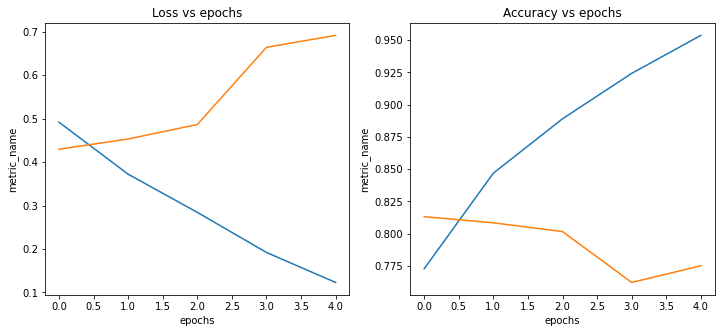

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_train_val_metrics(ax1, train_loss, val_loss, "Loss")
plot_train_val_metrics(ax2, train_acc, val_acc, "Accuracy")

In [133]:
best_model = torch.load("best_model.pt")
best_model

DisasterModel(
  (emb_layer): Embedding(14568, 200)
  (lstm_layer): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [162]:
df_test.head(10)

,id,keyword,location,text,processed_text,prcsd_tweet_len,vectorized_tweet
0,0,no_keyword,NaN,Just happened a terrible car crash,happened terrible car crash,4,"[tensor(758), tensor(1796), tensor(39), tensor(27)]"
1,2,no_keyword,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different city stay safe everyone,7,"[tensor(378), tensor(157), tensor(992), tensor(97), tensor(443), tensor(1592), tensor(137)]"
2,3,no_keyword,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose fleeing across street cannot save,10,"[tensor(103), tensor(2), tensor(609), tensor(2837), tensor(0), tensor(4449), tensor(702), tensor(444), tensor(1195), tensor(257)]"
3,9,no_keyword,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,4,"[tensor(347), tensor(3441), tensor(13034), tensor(76)]"
4,11,no_keyword,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,5,"[tensor(132), tensor(560), tensor(104), tensor(247), tensor(1024)]"
5,12,no_keyword,NaN,We're shaking...It's an earthquake,shakingit earthquake,2,"[tensor(0), tensor(157)]"
6,21,no_keyword,NaN,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",probably still show life arsenal yesterday,6,"[tensor(636), tensor(25), tensor(161), tensor(23), tensor(1830), tensor(1348)]"
7,22,no_keyword,NaN,Hey! How are you?,hey,1,[tensor(575)]
8,27,no_keyword,NaN,What a nice hat?,nice hat,2,"[tensor(1082), tensor(573)]"
9,29,no_keyword,NaN,Fuck off!,fuck,1,[tensor(279)]


In [135]:
tweet_vocab.set_default_index(0)
df_test["vectorized_tweet"] = df_test["processed_text"].apply(
    lambda row:torch.LongTensor(tweet_vocab.lookup_indices(row.split()))
    )

In [169]:
test_output = []
for index, row in df_test.iterrows():    
    vec_tweet = row["vectorized_tweet"]
    if len(vec_tweet) == 0:
        test_output.append(0)
        continue
    vec_tweet_len = torch.IntTensor([len(vec_tweet)])
    vec_tweet = vec_tweet.view(1, -1)    
    #print(vec_tweet, vec_tweet_len)
    output, (h_n,c_n) = best_model(vec_tweet, vec_tweet_len, state=None)
    #print(output)
    test_output.append(round(output.item()))    

len(test_output)

3263

In [170]:
test_output

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,


In [171]:
df_submission = pd.read_csv('./data/submission.csv')
df_submission['target']= test_output
df_submission.to_csv('my_submission2.csv',index=False)

In [137]:
val_dl_iter = iter(val_dl)
input, input_len, label = next(val_dl_iter)
input.shape

torch.Size([64, 17])

In [150]:
input = df_test["vectorized_tweet"][1]
input_len = len(input)
input = input.view(1, -1)
input_len = torch.IntTensor([input_len])
input, input_len

(tensor([[ 378,  157,  992,   97,  443, 1592,  137]]),
 tensor([7], dtype=torch.int32))

In [155]:
output, (h_n,c_n) = model(input, input_len, state=None)

In [156]:
output.item()

0.9378412365913391